In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T054639Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D47e34bc5489e23d53a50caaa1dcb75ceca5d1646ce2bb080cf750ad6eb9cb90febbe89916a453a659cb0e66c3835a35fbcb24909c5b11bf0a8dd2b80b1ed199386a0926b48fa758df27b02df6ad2da112d4f3cf923e246c2c4dc217774646f590869d58e8972b48c5d65da1dc205c09ee917d57209f4578a9e0e5247c5acd5c98ebdf7fb8b9607102a77b6ebda3d28a57855c39a7305058a853e985e29cc10aa56d102684f4a0bcb1e3c229971ac058f3de0c59c74f4520b0f54fee24cde07f98a2f2f59771623dde4bc9e5b147d22677db569d688c124047769c18787dd5b3bc085213f41301f405bda6712e7e05eecd49ba83575ae79e6e6243c50d654098c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg/300px-Chest_X-ray_in_influenza_and_Haemophilus_influenzae_-_annotated.jpg">


Speaking Neural Network now. We used a pretrained DenseNet121 with a different classifier of 4 layer (1024 -> 256 -> 32 -> 2) using RELU as an activation function and a dropout with a 30% probability.

We trained the whole network for 20 epochs including the pretrained part of the Densenet121, then we trained the classifier only for another 20 epochs.

Can you guess the final accuracy on the test set?

In [ ]:
import torchvision
from torchvision import transforms,models,datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import seaborn as sns



we load the data now, our data is divided into 3 main folders train,validation and test set ,we will start in the first time by creating a dic of the data path so it will be easy to work with

In [ ]:
data_dir = {
            'train': '../input/chest_xray/chest_xray/test',
            'test': '../input/chest_xray/chest_xray/test',
            'valid': '../input/chest_xray/chest_xray/val',
            }

we will use a data loaders and transformers to transform our data from images to torch tensors

In [ ]:
batch_size = 32 # we will set the batch size to 64

data_transforms = {
            'train': transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(), # randomly flip and rotate
                        transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),

            'test': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),

            'valid': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            }
# Load the datasets with ImageFolder

data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'test': torchvision.datasets.ImageFolder(data_dir['test'], data_transforms['test']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

# Using the image datasets and the trainforms, define the dataloaders
data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size,shuffle=True),
        'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size,shuffle=True),
        'valid': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size,shuffle=True),
        }

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = data_set['valid'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}


Let's now define the model that we talked about earlier in this notebook

In [ ]:
model = models.densenet121(pretrained=True) # we will use a pretrained model and we are going to change only the last layer
for param in model.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 145MB/s]


Trainning tiime! let's first define a trainning function for reusability, then we will use it train our model.
This function also print some trainning information that we can use to debug any problem that may appear

In [ ]:
def train_function(model, train_loader, valid_loader, criterion, optimizer, scheduler=None,
                       train_on_gpu=False, n_epochs=30, save_file='mymodel.pth'):

    valid_loss_min = np.Inf
    if train_on_gpu:
        model.cuda()
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(1, n_epochs + 1):
        if scheduler != None:
            scheduler.step()

        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0
        train_total = 0
        valid_correct = 0
        valid_total = 0

        model.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, 1)
            train_correct += torch.sum(pred == target.data)
            train_total += data.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = (100 * train_correct / train_total)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, 1)
            valid_correct += torch.sum(pred == target.data)
            valid_total += data.size(0)

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = (100 * valid_correct / valid_total)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print('Epoch: {} \n-----------------\n \tTraining Loss: {:.6f} \t Validation Loss: {:.6f} \t Training Accuracy: {:.4f}% \t Validation Accuracy: {:.4f}%'.format(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_file)
            valid_loss_min = valid_loss

    return train_losses, valid_losses, train_accuracies, valid_accuracies


Epoch: 1 
-----------------
 	Training Loss: -26.696999 	 Validation Loss: -103.478003 	 Training Accuracy: 69.7115% 	 Validation Accuracy: 37.3397%
Validation loss decreased (inf --> -103.478003).  Saving model ...
Epoch: 2 
-----------------
 	Training Loss: -238.138533 	 Validation Loss: -795.566311 	 Training Accuracy: 77.2436% 	 Validation Accuracy: 39.9038%
Validation loss decreased (-103.478003 --> -795.566311).  Saving model ...
Epoch: 3 
-----------------
 	Training Loss: -2922.992018 	 Validation Loss: -6565.094288 	 Training Accuracy: 62.6603% 	 Validation Accuracy: 62.5000%
Validation loss decreased (-795.566311 --> -6565.094288).  Saving model ...
Epoch: 4 
-----------------
 	Training Loss: -26783.303085 	 Validation Loss: -1608872.557692 	 Training Accuracy: 62.5000% 	 Validation Accuracy: 38.4615%
Validation loss decreased (-6565.094288 --> -1608872.557692).  Saving model ...
Epoch: 5 
-----------------
 	Training Loss: -172020.934095 	 Validation Loss: -45209.061398 	 

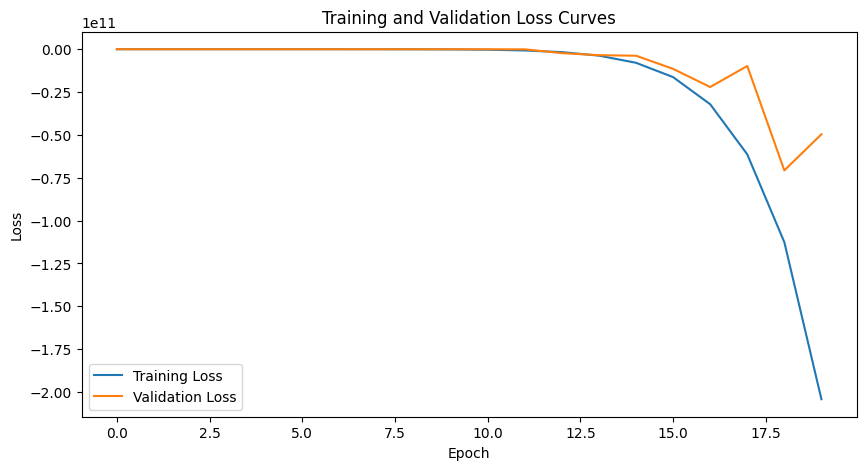

Test Loss: -49475768115.199997
Test Accuracy: 62.5000%


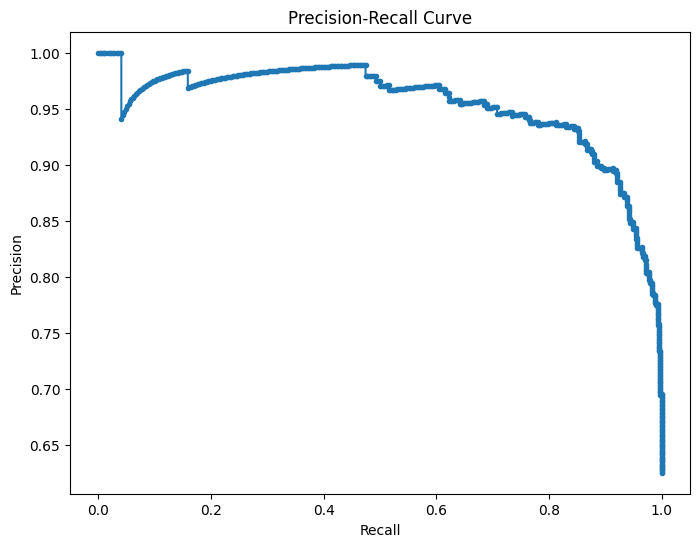

In [ ]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
import numpy as np

# Define optimizer
optimizer = optim.Adadelta(model.parameters())

# Define criterion
criterion = nn.NLLLoss()

# Check if GPU is available
train_on_gpu = torch.cuda.is_available()

# Call train_function to get training and validation losses and accuracies
train_losses, valid_losses, train_accuracies, valid_accuracies = train_function(
    model,
    data_loader['train'],
    data_loader['valid'],
    criterion=criterion,  # Pass criterion here
    optimizer=optimizer,  # Pass optimizer here
    scheduler=None,
    train_on_gpu=train_on_gpu,  # Pass train_on_gpu here
    n_epochs=20,
    save_file='saved_state.pth'
)



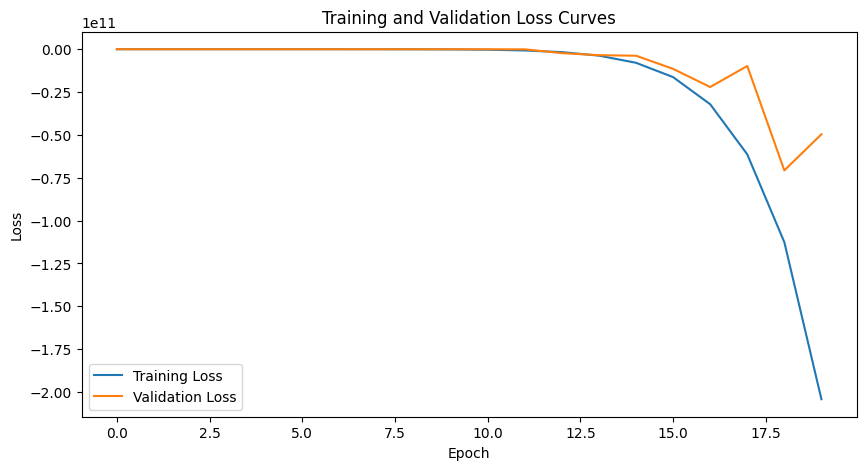

Test Loss: -49454366003.199997
Test Accuracy: 62.5000%


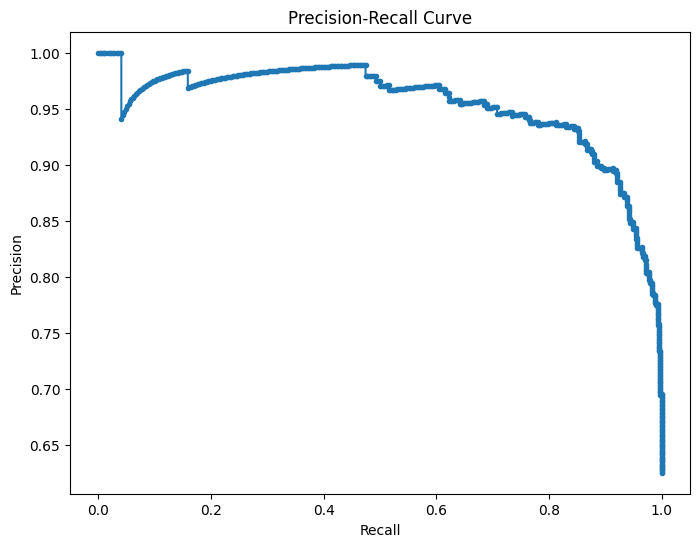

In [ ]:

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Evaluate the model on the test set
test_losses, test_accuracies = [], []
test_correct = 0
test_total = 0
y_true, y_scores = [], []

model.eval()
for data, target in data_loader['test']:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_losses.append(loss.item())
    _, pred = torch.max(output, 1)
    test_correct += torch.sum(pred == target.data)
    test_total += data.size(0)
    y_true.extend(target.cpu().numpy())
    y_scores.extend(output[:, 1].detach().cpu().numpy())

test_accuracy = (100 * test_correct / test_total).item()
test_losses = np.mean(test_losses)
print('Test Loss: {:.6f}'.format(test_losses))
print('Test Accuracy: {:.4f}%'.format(test_accuracy))


# Plot precision-recall curve
plot_precision_recall_curve(y_true, y_scores)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

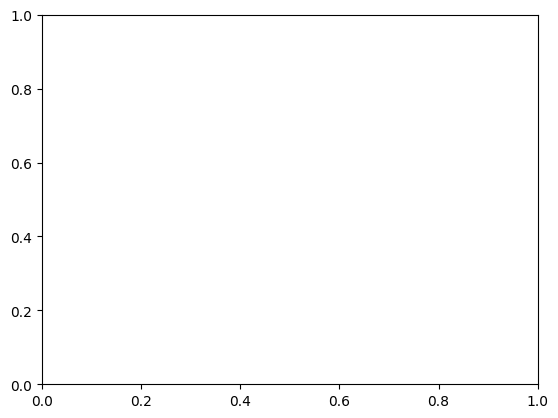

In [ ]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

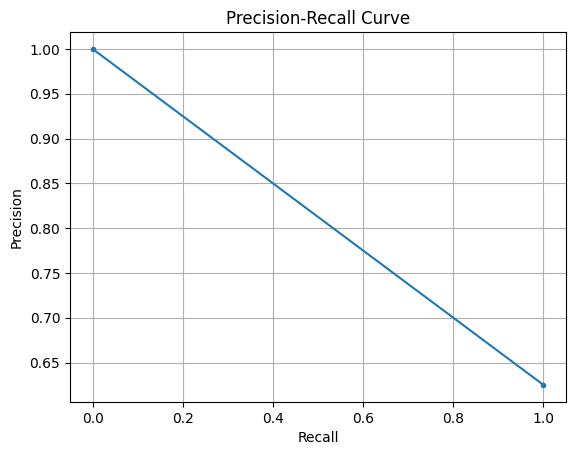

In [ ]:
from sklearn.metrics import precision_recall_curve

# Load the test data and perform predictions
test_loader = data_loader['test']

def get_predictions(model, data_loader):
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return predictions, targets

# Get predictions and targets
test_predictions, test_targets = get_predictions(model, test_loader)

# Compute precision and recall
precision, recall, _ = precision_recall_curve(test_targets, test_predictions)

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


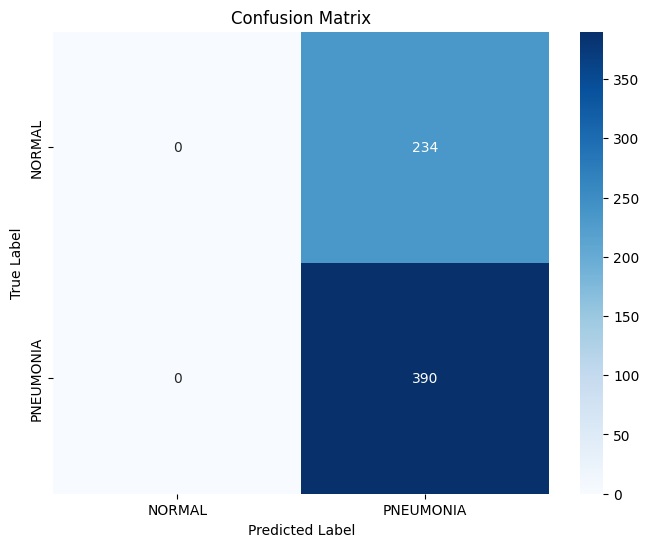

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(test_targets, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cat_to_name.values(), yticklabels=cat_to_name.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Test Loss: -49623136051.199997
Test Accuracy: 62.5000%


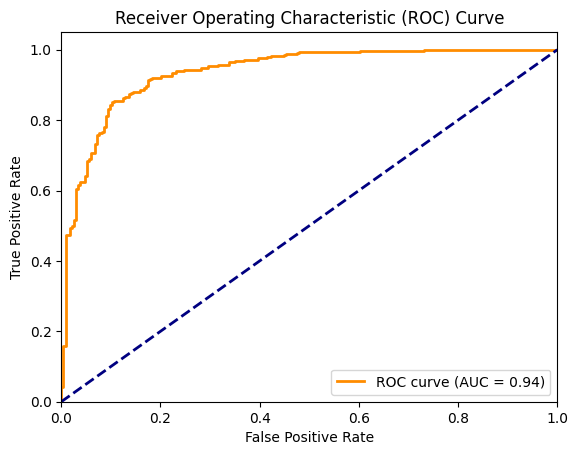

In [ ]:
# Evaluate the model on the test set
test_losses, test_accuracies = [], []
test_correct = 0
test_total = 0
y_true, y_scores = [], []

model.eval()
for data, target in data_loader['test']:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_losses.append(loss.item())
    _, pred = torch.max(output, 1)
    test_correct += torch.sum(pred == target.data)
    test_total += data.size(0)
    y_true.extend(target.cpu().numpy())
    y_scores.extend(output[:, 1].detach().cpu().numpy())

test_accuracy = (100 * test_correct / test_total).item()
test_losses = np.mean(test_losses)
print('Test Loss: {:.6f}'.format(test_losses))
print('Test Accuracy: {:.4f}%'.format(test_accuracy))

# Plot ROC Curve
plot_roc_curve(y_true, y_scores)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

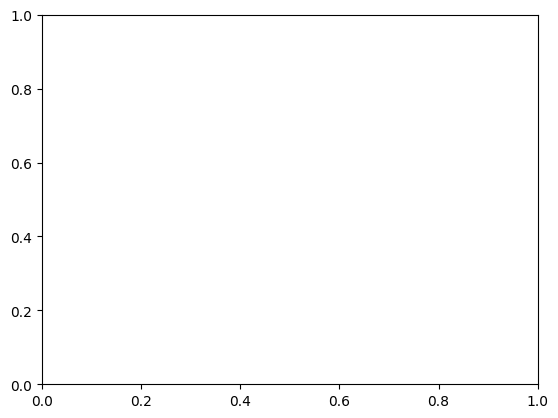

In [ ]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

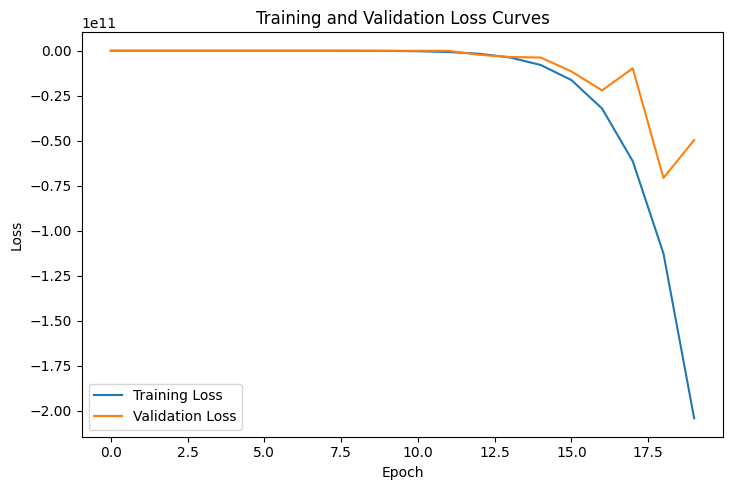

NameError: name 'n_epochs' is not defined

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import roc_curve, auc

# Function to plot learning rate schedule
def plot_lr_schedule(optimizer, n_epochs):
    lr_values = []
    for epoch in range(n_epochs):
        optimizer.step()
        lr_values.append(optimizer.param_groups[0]['lr'])

    plt.plot(range(1, n_epochs + 1), lr_values)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

# Function to plot training and validation accuracy curves
def plot_accuracy_curves(train_accuracies, valid_accuracies):
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plotting loss and accuracy curves
plt.figure(figsize=(14, 5))

plt.tight_layout()
plt.show()

# Plot Learning Rate Schedule
plot_lr_schedule(optimizer, n_epochs)




let's see if we can train our model on GPU , the training in the GPU is so much faster than CPU so it will be great if we can use it

In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('GPU is  available :)   Training on GPU ...')
else:
    print('GPU is not available :(  Training on CPU ...')

GPU is  available :)   Training on GPU ...


After we trained our model we have to see  how it will classify data that it has never seen before, in our case it's the test set

In [ ]:
def test_function(model, test_loader, train_on_gpu, criterion,classes):
    test_loss = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    if train_on_gpu:
        model.cuda()
    model.eval()
    cat_accuracy = {}
    if train_on_gpu:
        model.cuda()
    for data,target in test_loader:
        if train_on_gpu:
            data,target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)

        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu \
                                else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(data.shape[0]):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy (Overall): %2d%% (%2d/%2d) \n ----------------------' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %s : %d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %s: N/A (no training examples)' % (classes[str(i+1)]))



Let's see if you guessed the exact accuracy ...

In [ ]:
criterion = nn.NLLLoss()
test_function(model, data_loader['test'], train_on_gpu, criterion, cat_to_name)

we have obtained 99% of test accuracy with just 40 epochs !! tha's great !!

Now let's try to create some exta functions to allow our model to work with a real data (data from the web which we don't know the size ),so we create a process_image to preprocess the input which is the to be able to feed the model and see the out put and another function to show the image sow we can easily see the input  to our model and another to predict and see the probability of being noraml or sick and the last function is the function of plot that use all the other functions to predict show and plot the proba of an input

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    ##########Scales
    if img.size[0] > img.size[1]:
        img.thumbnail((1000000, 256))
    else:
        img.thumbnail((256 ,1000000))
    #######Crops: to crop the image we have to specifiy the left,Right,button and the top pixels because the crop function take a rectongle ot pixels
    Left = (img.width - 224) / 2
    Right = Left + 224
    Top = (img.height - 244) / 2
    Buttom = Top + 224
    img = img.crop((Left, Top, Right, Buttom))
    img = np.stack((img,)*3, axis=-1)# to repeate the the one chanel of a gray image to be RGB image
    #img = np.repeat(image[..., np.newaxis], 3, -1)
    #print(np.array(img).shape)
    #normalization (divide the image by 255 so the value of the channels will be between 0 and 1 and substract the mean and divide the result by the standtared deviation)
    img = ((np.array(img) / 255) - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    img = img.transpose((2, 0, 1))
    return img

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension

    image = image.transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    #image=np.transpose(image)
    ax.imshow(image)

    return ax

In [ ]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    img = process_image(image_path)
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    model_input = image_tensor.unsqueeze(0)
    probs = torch.exp(model.forward(model_input))

    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs = top_probs.detach().numpy().tolist()[0]
    top_labs = top_labs.detach().numpy().tolist()[0]

    # Convert indices to classes
    #top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[lab] for lab in top_labs]

    return top_probs, top_flowers
    # TODO: Implement the code to predict the class from an image file

In [ ]:
def plot(image_path,model,top_k=2):
    proba, flowers = predict(image_path, model, top_k)
    plt.figure(figsize=(6,10))
    ax = plt.subplot(2,1,1)

    title = image_path.split('/')[5]
    imshow(process_image(image_path), ax, title=title)

    plt.subplot(2,1,2)
    sns.barplot(x=proba, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [ ]:
model.to('cpu')
plot('../input/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg',model,2)